# Imports

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import joblib

warnings.filterwarnings("ignore")


# Config & Reproducibility

In [2]:
SEED = 42
BASE_PATH = "/kaggle/input/csiro-biomass"
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 50
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Load & Pivot Dataset

In [3]:
df = pd.read_csv(os.path.join(BASE_PATH, "train.csv"))

df = df.pivot_table(
    index="image_path",
    columns="target_name",
    values="target"
).reset_index()

df.fillna(0, inplace=True)

TARGET_COLUMNS = [
    'Dry_Green_g',
    'Dry_Dead_g',
    'Dry_Clover_g',
    'GDM_g',
    'Dry_Total_g'
]

print("Dataset shape:", df.shape)


Dataset shape: (357, 6)


# Train / Validation Split & Scaling

In [4]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=SEED,
    shuffle=True
)

target_scaler = StandardScaler()
target_scaler.fit(train_df[TARGET_COLUMNS].values)


StandardScaler()

# Dataset Class

In [5]:
class BiomassDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, scaler=None):
        self.df = df.copy()
        self.df["image_path"] = self.df["image_path"].apply(os.path.basename)
        self.samples = list(self.df.itertuples(index=False))
        self.image_dir = image_dir
        self.transform = transform
        self.scaler = scaler

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        row = self.samples[idx]
        image = Image.open(
            os.path.join(self.image_dir, row.image_path)
        ).convert("RGB")

        if self.transform:
            image = self.transform(image)

        target = np.array(
            [getattr(row, t) for t in TARGET_COLUMNS],
            dtype=np.float32
        )

        if self.scaler:
            target = self.scaler.transform(target.reshape(1, -1))[0]

        return image, torch.tensor(target)


# Transforms (Medium Augmentation)

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


# DataLoaders

In [7]:
train_dataset = BiomassDataset(
    train_df,
    os.path.join(BASE_PATH, "train"),
    train_transforms,
    target_scaler
)

val_dataset = BiomassDataset(
    val_df,
    os.path.join(BASE_PATH, "train"),
    val_transforms,
    target_scaler
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)


# Weighted Loss & Metric

In [8]:
TARGET_WEIGHTS = torch.tensor([0.1,0.1,0.1,0.2,0.5], device=DEVICE)

class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super().__init__()
        self.register_buffer("weights", weights)

    def forward(self, preds, targets):
        return ((preds - targets) ** 2 * self.weights).mean()

criterion = WeightedMSELoss(TARGET_WEIGHTS)

def weighted_r2_score(y_true, y_pred, weights):
    mean_y = y_true.mean(0, keepdim=True)
    ss_res = ((y_true - y_pred) ** 2).sum(0)
    ss_tot = ((y_true - mean_y) ** 2).sum(0)
    return (1 - (weights * ss_res).sum() / ((weights * ss_tot).sum() + 1e-8)).item()


# Optimized CNN Architecture

In [9]:
class OptimizedCNN(nn.Module):
    def __init__(self, num_outputs=5):
        super().__init__()
        layers = []
        in_channels = 3
        num_filters = 256
        kernel_size = 5
        padding = kernel_size // 2
        dropout = 0.6

        for _ in range(3):
            layers += [
                nn.Conv2d(in_channels, num_filters, kernel_size, padding=padding),
                nn.BatchNorm2d(num_filters),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Dropout(dropout)
            ]
            in_channels = num_filters

        layers.append(nn.AdaptiveAvgPool2d(1))
        self.features = nn.Sequential(*layers)
        self.regressor = nn.Linear(num_filters, num_outputs)

    def forward(self, x):
        x = self.features(x)
        return self.regressor(x.flatten(1))


# Epoch Function

In [10]:
def run_epoch(model, loader, optimizer=None):
    training = optimizer is not None
    model.train() if training else model.eval()

    total_loss, total_r2, n = 0.0, 0.0, 0

    with torch.set_grad_enabled(training):
        for images, targets in loader:
            images, targets = images.to(DEVICE), targets.to(DEVICE)
            preds = model(images)
            loss = criterion(preds, targets)

            if training:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            b = images.size(0)
            total_loss += loss.item() * b
            total_r2 += weighted_r2_score(targets, preds, TARGET_WEIGHTS) * b
            n += b

    return total_loss / n, total_r2 / n


# Training Loop + Metrics + Best Model Saving

In [11]:
model = OptimizedCNN(num_outputs=len(TARGET_COLUMNS)).to(DEVICE)
optimizer = optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

train_losses, val_losses = [], []
train_r2s, val_r2s = [], []

best_val_r2 = -1e9

for epoch in range(NUM_EPOCHS):
    tr_l, tr_r2 = run_epoch(model, train_loader, optimizer)
    va_l, va_r2 = run_epoch(model, val_loader)

    train_losses.append(tr_l)
    val_losses.append(va_l)
    train_r2s.append(tr_r2)
    val_r2s.append(va_r2)

    if va_r2 > best_val_r2:
        best_val_r2 = va_r2
        torch.save(model.state_dict(), "best_model_weights.pth")
        joblib.dump(target_scaler, "target_scaler.pkl")

    print(
        f"Epoch {epoch+1}/{NUM_EPOCHS} | "
        f"Train R²: {tr_r2:.4f} | Val R²: {va_r2:.4f}"
    )


Epoch 1/50 | Train R²: -2.5632 | Val R²: -0.3428
Epoch 2/50 | Train R²: -0.0259 | Val R²: -0.0603
Epoch 3/50 | Train R²: -0.1429 | Val R²: -0.0355
Epoch 4/50 | Train R²: 0.0167 | Val R²: 0.0248
Epoch 5/50 | Train R²: -0.0315 | Val R²: 0.0520
Epoch 6/50 | Train R²: -0.0220 | Val R²: 0.0641
Epoch 7/50 | Train R²: 0.0246 | Val R²: 0.0579
Epoch 8/50 | Train R²: 0.0603 | Val R²: 0.1083
Epoch 9/50 | Train R²: 0.0606 | Val R²: 0.0971
Epoch 10/50 | Train R²: 0.0696 | Val R²: 0.0724
Epoch 11/50 | Train R²: -0.0471 | Val R²: 0.1064
Epoch 12/50 | Train R²: 0.0997 | Val R²: 0.1312
Epoch 13/50 | Train R²: -0.0658 | Val R²: 0.1252
Epoch 14/50 | Train R²: 0.0502 | Val R²: 0.1569
Epoch 15/50 | Train R²: 0.0690 | Val R²: 0.1514
Epoch 16/50 | Train R²: 0.0753 | Val R²: 0.1658
Epoch 17/50 | Train R²: 0.0556 | Val R²: 0.1309
Epoch 18/50 | Train R²: 0.1502 | Val R²: 0.1652
Epoch 19/50 | Train R²: 0.1371 | Val R²: 0.0891
Epoch 20/50 | Train R²: 0.0433 | Val R²: 0.1342
Epoch 21/50 | Train R²: 0.1232 | Val R²

# Average Metrics

In [12]:
print("\n===== FINAL AVERAGES =====")
print("Avg Train Loss:", np.mean(train_losses))
print("Avg Val Loss:", np.mean(val_losses))
print("Avg Train R²:", np.mean(train_r2s))
print("Avg Val R²:", np.mean(val_r2s))
print("Best Val R²:", best_val_r2)



===== FINAL AVERAGES =====
Avg Train Loss: 0.1700158616199828
Avg Val Loss: 0.1270503824452559
Avg Train R²: 0.044747793578265006
Avg Val R²: 0.03800841252009074
Best Val R²: 0.16577344470553929


# Plots

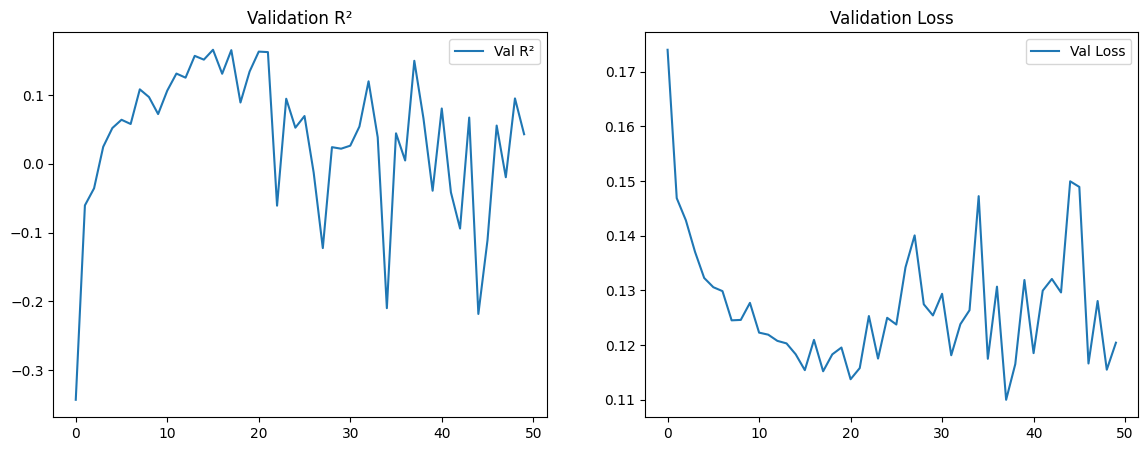

In [13]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(val_r2s, label="Val R²")
plt.title("Validation R²")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_losses, label="Val Loss")
plt.title("Validation Loss")
plt.legend()
plt.show()


# Inference

## Device & Paths

In [14]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BASE_PATH = "/kaggle/input/csiro-biomass"
TEST_DIR = f"{BASE_PATH}/test"

MODEL_PATH = "best_model_weights.pth"
SCALER_PATH = "target_scaler.pkl"


## Target Columns (Must Match Training)

In [15]:
TARGET_COLUMNS = [
    'Dry_Green_g',
    'Dry_Dead_g',
    'Dry_Clover_g',
    'GDM_g',
    'Dry_Total_g'
]


## Load Model Weights & Scaler

In [16]:
best_model = OptimizedCNN(num_outputs=len(TARGET_COLUMNS)).to(DEVICE)
best_model.load_state_dict(
    torch.load(MODEL_PATH, map_location=DEVICE)
)
best_model.eval()

target_scaler = joblib.load(SCALER_PATH)


## Image Transforms (Validation / Test Only)

In [17]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


## Test-Time Inference

In [18]:
submission_rows = []

with torch.no_grad():
    for file in tqdm(sorted(os.listdir(TEST_DIR))):
        image = Image.open(os.path.join(TEST_DIR, file)).convert("RGB")
        tensor = image_transforms(image).unsqueeze(0).to(DEVICE)

        preds_scaled = best_model(tensor).cpu().numpy()
        preds = target_scaler.inverse_transform(preds_scaled)[0]

        image_id = file.replace(".jpg", "")

        for name, value in zip(TARGET_COLUMNS, preds):
            submission_rows.append({
                "sample_id": f"{image_id}__{name}",
                "target": float(max(0.0, value))  # clamp negatives
            })


100%|██████████| 1/1 [00:00<00:00, 12.07it/s]


## Save Submission File

In [19]:
submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv("submission.csv", index=False)

submission_df.head()


,sample_id,target
0,ID1001187975__Dry_Green_g,14.425188
1,ID1001187975__Dry_Dead_g,18.043287
2,ID1001187975__Dry_Clover_g,2.452188
3,ID1001187975__GDM_g,19.589367
4,ID1001187975__Dry_Total_g,38.649136
